# 1. Notebook Setup

Import libraries

In [75]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import eda as eda
import helper as hlp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Loading and Prepare data

Load CSV file that contains GHI

In [3]:
df = pd.read_csv("../data/Folsom_irradiance.csv", infer_datetime_format=True)
df

,timeStamp,ghi,dni,dhi
0,2014-01-02 08:00:00,0.0,0.0,0.0
1,2014-01-02 08:01:00,0.0,0.0,0.0
2,2014-01-02 08:02:00,0.0,0.0,0.0
3,2014-01-02 08:03:00,0.0,0.0,0.0
4,2014-01-02 08:04:00,0.0,0.0,0.0
...,...,...,...,...
1552315,2016-12-31 07:55:00,0.0,0.0,0.0
1552316,2016-12-31 07:56:00,0.0,0.0,0.0
1552317,2016-12-31 07:57:00,0.0,0.0,0.0
1552318,2016-12-31 07:58:00,0.0,0.0,0.0


Convert `timeStamp` to a datetime and rename to `ds` (correct format for Prophet)

In [4]:
df["ds"] = pd.to_datetime(df["timeStamp"])

Drop night time rows:
* only keep between 5:39am to 8:33pm
* based on shortest days using as per https://www.timeanddate.com/sun/@5349705?month=1&year=2014

Potential improvements:

* use timeanddate API for exact every day for more accurate data filtering: https://dev.timeanddate.com/

In [5]:
# Define the start and end times for the filter (e.g., from 08:30 AM to 04:45 PM)
start_time = '05:39:00'
end_time = '20:33:00'

# Convert start and end times to datetime objects
start_datetime = pd.to_datetime(start_time, format='%H:%M:%S').time()
end_datetime = pd.to_datetime(end_time, format='%H:%M:%S').time()

df_filtered = df[
    (df['ds'].dt.time >= start_datetime) & 
    (df['ds'].dt.time < end_datetime)
]

print(f"Size before: {df.shape[0]}")
print(f"Size after filtering: {df_filtered.shape[0]}")
print(f"Decrease in original volume = {round((df_filtered.shape[0] - df.shape[0]) / abs(df.shape[0]) * 100, 1)}%")
df_filtered

Size before: 1552320
Size after filtering: 963732
Decrease in original volume = -37.9%


,timeStamp,ghi,dni,dhi,ds
0,2014-01-02 08:00:00,0.0,0.0,0.0,2014-01-02 08:00:00
1,2014-01-02 08:01:00,0.0,0.0,0.0,2014-01-02 08:01:00
2,2014-01-02 08:02:00,0.0,0.0,0.0,2014-01-02 08:02:00
3,2014-01-02 08:03:00,0.0,0.0,0.0,2014-01-02 08:03:00
4,2014-01-02 08:04:00,0.0,0.0,0.0,2014-01-02 08:04:00
...,...,...,...,...,...
1552315,2016-12-31 07:55:00,0.0,0.0,0.0,2016-12-31 07:55:00
1552316,2016-12-31 07:56:00,0.0,0.0,0.0,2016-12-31 07:56:00
1552317,2016-12-31 07:57:00,0.0,0.0,0.0,2016-12-31 07:57:00
1552318,2016-12-31 07:58:00,0.0,0.0,0.0,2016-12-31 07:58:00


In [6]:
df = df_filtered.copy()

Drop other columns (only GHI needed for Prophet) and rename to `y`

In [7]:
df["y"] = df["ghi"]
df = df[["ds", "y"]]

Split train/test

In [8]:
# Split data into train and test based on the years
train_start = "2014-01-01"
test_start = "2016-01-01"

df_train = df.loc[df["ds"] < test_start]
df_test = df.loc[df["ds"] >= test_start]

Ensure no data leakage by checking date range of each sample created

In [9]:
eda.print_df_date_range(df_train, "ds", "Train")
eda.print_df_date_range(df_test, "ds", "Test")

Train dataset date ranges = 2014-01-02 08:00:00 to 2015-12-31 07:59:00

Test dataset date ranges = 2016-01-01 08:00:00 to 2016-12-31 07:59:00



# 3. Train Prophet Model

## a. Default Base Model

Runtimes:
* Takes ~ 10 minutes on full train test (all 2014 and 2015)
* Takes ~ 6 minutes on filtered train test (all 2014 and 2015, no nighttime)

In [28]:
# # Create a Prophet model instance
# model = Prophet()

# model.fit(df_train)

# hlp.save_prophet_model(model, '../output/prophet_univariate_default_serialized_model.json')

Takes ~10 seconds

In [57]:
model = hlp.load_prophet_model('../output/prophet_univariate_default_serialized_model.json')

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


## b. Hyperparameter optimisation

Define grid search space

In [79]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10],
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
}

param_grid = {
    'changepoint_prior_scale': [0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10],
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ['multiplicative'],
}

Train and cross-validate  on 2014 only for faster grid search

In [73]:
df_train_2014 = df_train[df_train["ds"] < "2015-01-01"]
df_train_2014

,ds,y
0,2014-01-02 08:00:00,0.0
1,2014-01-02 08:01:00,0.0
2,2014-01-02 08:02:00,0.0
3,2014-01-02 08:03:00,0.0
4,2014-01-02 08:04:00,0.0
...,...,...
506188,2014-12-31 20:28:00,502.6
506189,2014-12-31 20:29:00,501.7
506190,2014-12-31 20:30:00,501.0
506191,2014-12-31 20:31:00,500.4


In [80]:
# Initialize lists to store hyperparameter combinations and corresponding MAE
hyperparameters = []
mae_values = []
rmse_values = []
iteration_num = 0

# Iterate through hyperparameter combinations
for changepoint_prior in param_grid['changepoint_prior_scale']:
    for seasonality_prior in param_grid['seasonality_prior_scale']:
        for holidays_prior in param_grid['holidays_prior_scale']:
            for seasonality_mode in param_grid['seasonality_mode']:
                iteration_num =+ 1
                print(f"Iteration #{iteration_num}" + \
                      f"\nchangepoint_prior_scale = {changepoint_prior}" + \
                      f"\nseasonality_prior_scale = {seasonality_prior}" + \
                      f"\nholidays_prior_scale = {holidays_prior}" + \
                      f"\nseasonality_mode = {seasonality_mode}")
                
                if changepoint_prior == 0.5 and seasonality_prior == 10 and holidays_prior == 10 and seasonality_mode == "multiplicative":
                    print("\nskipping current loop\n")
                    break
                
                # Create a Prophet model instance with current hyperparameters
                model = Prophet(
                    changepoint_prior_scale=changepoint_prior,
                    seasonality_prior_scale=seasonality_prior,
                    holidays_prior_scale=holidays_prior,
                    seasonality_mode=seasonality_mode,
                )
                
                # Fit the model with your training dataset (data from 2014 and 2015)
                print("fitting model...")
                model.fit(df_train_2014)
                
                # Perform cross-validation to evaluate the model's performance
                print("performing cross-validation...")
                df_cv = cross_validation(model, 
                                         initial='334 days', 
                                         period='10 day', 
                                         horizon='20 minutes',
                                         parallel="processes")
                
                # Calculate Mean Absolute Error (MAE) and RMSE for cross-validation
                mae = performance_metrics(df_cv)['mae'].mean()
                rmse = np.sqrt(performance_metrics(df_cv)['mse'].mean())
                print(f"MAE = {mae}\nRMSE = {rmse}")
                
                # Store hyperparameters and corresponding MAE and RMSE
                hyperparameters.append({
                    'changepoint_prior_scale': changepoint_prior,
                    'seasonality_prior_scale': seasonality_prior,
                    'holidays_prior_scale': holidays_prior,
                    'seasonality_mode': seasonality_mode,
                })
                mae_values.append(mae)
                rmse_values.append(rmse)
                print()

Iteration #1
changepoint_prior_scale = 0.05
seasonality_prior_scale = 10
holidays_prior_scale = 10
seasonality_mode = multiplicative
fitting model...


15:12:29 - cmdstanpy - INFO - Chain [1] start processing
15:17:36 - cmdstanpy - INFO - Chain [1] done processing


performing cross-validation...


15:17:57 - cmdstanpy - INFO - Chain [1] start processing
15:17:59 - cmdstanpy - INFO - Chain [1] start processing
15:17:59 - cmdstanpy - INFO - Chain [1] start processing
15:25:33 - cmdstanpy - INFO - Chain [1] done processing
15:25:59 - cmdstanpy - INFO - Chain [1] done processing
15:26:07 - cmdstanpy - INFO - Chain [1] done processing


MAE = 166.03543378549293
RMSE = 207.05436140232368



Visualise grid search results (manually exported to Excel from console output and processed using automated functions)

In [95]:
df_grid_search = pd.read_excel("../output/prophet_univariate_grid_search.xlsx").set_index("Iteration")
best_params = df_grid_search.sort_values(by=["MAE"], ascending=True)[['changepoint_prior_scale', 'seasonality_prior_scale', 'holidays_prior_scale', 'seasonality_mode']].iloc[0].to_dict()
best_params

{'changepoint_prior_scale': 0.05,
 'seasonality_prior_scale': 1.0,
 'holidays_prior_scale': 0.1,
 'seasonality_mode': 'multiplicative'}

<AxesSubplot:xlabel='Iteration'>

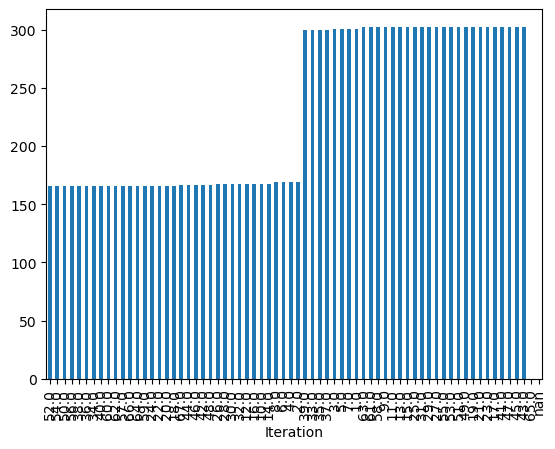

In [100]:
df_grid_search.sort_values(by=["MAE"], ascending=True)["MAE"].plot(kind="bar")

manually chose values from https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation on final model

Runtimes:
* Takes ~ 10 minutes on full train test (all 2014 and 2015)
* Takes ~ 6 minutes on filtered train test (all 2014 and 2015, no nighttime)

In [112]:
# # Create a Prophet model instance
# model = Prophet(
#     changepoint_prior_scale=best_params["changepoint_prior_scale"],
#     seasonality_prior_scale=best_params["seasonality_prior_scale"],
#     holidays_prior_scale=best_params["holidays_prior_scale"],
#     seasonality_mode=best_params["seasonality_mode"]
# )

# model.fit(df_train)

# hlp.save_prophet_model(model, '../output/prophet_univariate_optimised_serialized_model.json')

15:37:28 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] done processing


Successfully saved model at ../output/prophet_univariate_optimised_serialized_model.json


Takes ~10 seconds

In [57]:
model = hlp.load_prophet_model('../output/prophet_univariate_optimised_serialized_model.json')

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


# 4. Make Forecasting Predictions

Loop through each minute prediction from 1 to 20, forecasts the next minute step using the ARIMA model, stores the forecasted values in a DataFrame, calculates the errors at each minute prediction, and plots the mean absolute error at each forecast horizon.

In [36]:
df_train.tail(5)

,ds,y
1029595,2015-12-31 07:55:00,0.0
1029596,2015-12-31 07:56:00,0.0
1029597,2015-12-31 07:57:00,0.0
1029598,2015-12-31 07:58:00,0.0
1029599,2015-12-31 07:59:00,0.0


In [25]:
future = model.make_future_dataframe(periods=20, freq='min', include_history=True)  # 20 minutes with 1-minute intervals
future.tail(22)



,ds
639208,2015-12-31 07:58:00
639209,2015-12-31 07:59:00
639210,2015-12-31 08:00:00
639211,2015-12-31 08:01:00
639212,2015-12-31 08:02:00
639213,2015-12-31 08:03:00
639214,2015-12-31 08:04:00
639215,2015-12-31 08:05:00
639216,2015-12-31 08:06:00
639217,2015-12-31 08:07:00


In [114]:
future = df_test[["ds"]]
future = future.loc[future["ds"] < '2016-01-02']

future

,ds
1029600,2016-01-01 08:00:00
1029601,2016-01-01 08:01:00
1029602,2016-01-01 08:02:00
1029603,2016-01-01 08:03:00
1029604,2016-01-01 08:04:00
...,...
1030348,2016-01-01 20:28:00
1030349,2016-01-01 20:29:00
1030350,2016-01-01 20:30:00
1030351,2016-01-01 20:31:00


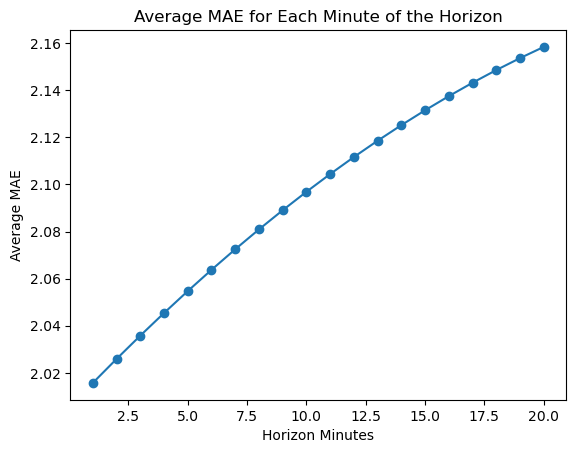

In [115]:
# Make predictions for the future
forecast = model.predict(future)

# Extract the forecasted values for the test set (the last 20 minutes)
forecast_test = forecast.iloc[-20:]

# Initialize lists to store MAE for each minute of the horizon
mae_per_minute = []

# Iterate over each minute of the horizon (from 1 to 20)
for minute in range(1, 21):
    # Filter the forecasted values up to the current minute
    forecast_until_minute = forecast.iloc[:minute]
    
    # Filter the actual values up to the current minute
    actual_until_minute = df_test.iloc[:minute]
    
    # Calculate MAE for this minute and append it to the list
    mae = mean_absolute_error(actual_until_minute['y'], forecast_until_minute['yhat'])
    mae_per_minute.append(mae)

# Plot the average error for each minute of the horizon
plt.plot(range(1, 21), mae_per_minute, marker='o')
plt.xlabel('Horizon Minutes')
plt.ylabel('Average MAE')
plt.title('Average MAE for Each Minute of the Horizon')
plt.show()

In [12]:
future = model.make_future_dataframe(periods=len(test_data), freq='min')

,ds,y
1029600,2016-01-01 08:00:00,0.0
1029601,2016-01-01 08:01:00,0.0
1029602,2016-01-01 08:02:00,0.0
1029603,2016-01-01 08:03:00,0.0
1029604,2016-01-01 08:04:00,0.0
...,...,...
1039595,2016-01-08 06:35:00,0.0
1039596,2016-01-08 06:36:00,0.0
1039597,2016-01-08 06:37:00,0.0
1039598,2016-01-08 06:38:00,0.0


/tmp/ipykernel_30240/17356512.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future = future.append(test_batch[['ds']], ignore_index=True)


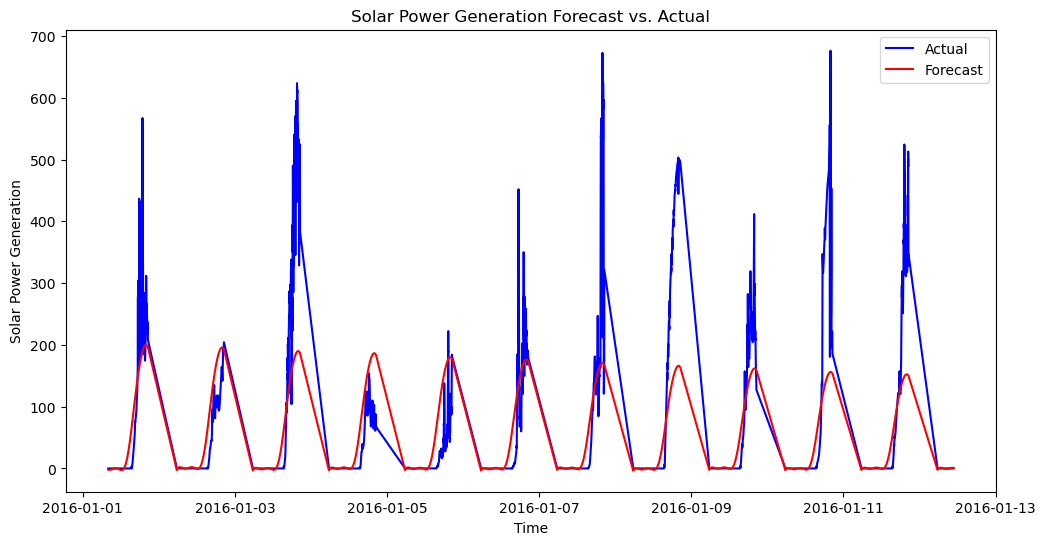

Mean Absolute Error (MAE) for the entire test set: 39.40868662891964


In [113]:
# Set the batch size for making predictions
batch_size = 10000  # Adjust as needed based on your available memory

# Initialize lists to store forecasted values and actual values
forecast_values = []
actual_values = []

# Loop through the test dataset in batches
for i in range(0, len(df_test), batch_size):
    # Extract a batch of test data
    test_batch = df_test.iloc[i:i + batch_size]
    
    # Update the future DataFrame with the current batch of test data
    future = future.append(test_batch[['ds']], ignore_index=True)
    
    # Make predictions for the current batch
    forecast = model.predict(future[-len(test_batch):])
    
    # Append the forecasted values to the list
    forecast_values.extend(forecast['yhat'].values)
    
    # Append the actual values to the list
    actual_values.extend(test_batch['y'].values)
    break

# Calculate the mean absolute error (MAE) for the entire test set
mae = mean_absolute_error(actual_values, forecast_values)

# Plot the forecasted vs. actual values for the test set
plt.figure(figsize=(12, 6))
plt.plot(df_test[:10000]['ds'], actual_values, label='Actual', color='b')
plt.plot(df_test[:10000]['ds'], forecast_values, label='Forecast', color='r')
plt.xlabel('Time')
plt.ylabel('GHI')
plt.title('GHI Forecast vs. Actual')
plt.legend()
plt.show()

print(f'Mean Absolute Error (MAE) for the entire test set: {mae}')

i=10000
i=10100


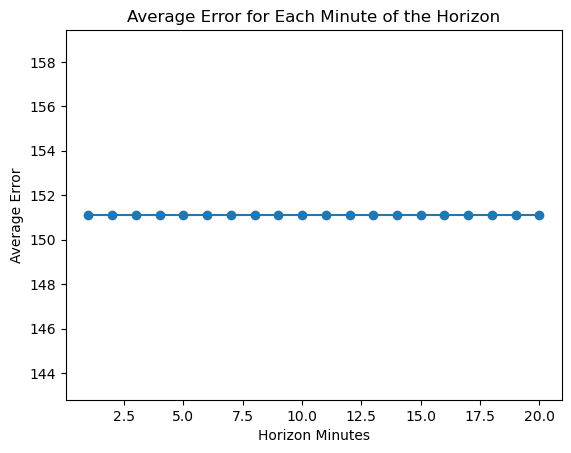

In [12]:
# Initialize lists to store errors for each minute of the horizon
errors_per_minute = [[] for _ in range(20)]

# Set the batch size for making predictions
batch_size = 100  # Adjust as needed based on your available memory

# Loop through each row in the test set in batches
for i in range(10000, 10110, batch_size): #len(df_test)
    print(f"i={i}")
    test_batch = df_test.iloc[i:i + batch_size]
    
    # Loop through each row in the batch
    for _, test_row in test_batch.iterrows():
        # Create a future DataFrame for making predictions
        future = model.make_future_dataframe(periods=20, freq='min', include_history=False)
        
        # Set the 'ds' column in the future DataFrame to the current timestamp from the test row
        future['ds'] = test_row['ds']
        
        # Make predictions for the 20-minute horizon
        forecast = model.predict(future)
        
        # Extract the actual values for the next 20 minutes
        actual_values = test_row['y']
        
        # Calculate the errors at each predicted minute and store them
        for j in range(20):
            predicted_value = forecast['yhat'].iloc[j]
            error = abs(actual_values - predicted_value)
            errors_per_minute[j].append(error)

# Calculate the average error for each minute of the horizon
average_errors = [np.mean(errors) for errors in errors_per_minute]

# Plot the average error for each minute of the horizon


plt.plot(range(1, 21), average_errors, marker='o')
plt.xlabel('Horizon Minutes')
plt.ylabel('Average Error')
plt.title('Average Error for Each Minute of the Horizon')
plt.show()


In [51]:
df_test_single_day = df_test[df_test["ds"] < "2016-01-03"]

In [57]:
df_test_single_day.set_index("ds")

,y
ds,
2016-01-01 08:00:00,0.0
2016-01-01 08:01:00,0.0
2016-01-01 08:02:00,0.0
2016-01-01 08:03:00,0.0
2016-01-01 08:04:00,0.0
...,...
2016-01-02 20:28:00,197.0
2016-01-02 20:29:00,199.8
2016-01-02 20:30:00,199.9


<AxesSubplot:>

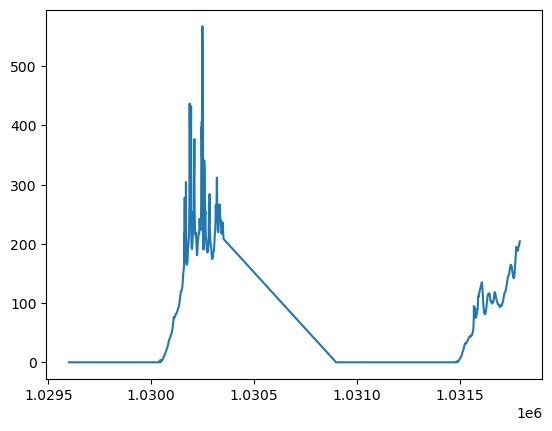

In [58]:
df_test_single_day.y.plot()

In [60]:
eda.print_df_date_range(df_test_single_day, "ds", sample_str="None")

None dataset date ranges = 2016-01-01 08:00:00 to 2016-01-02 20:32:00



In [54]:
df_test_single_day

,ds,y
1029600,2016-01-01 08:00:00,0.0
1029601,2016-01-01 08:01:00,0.0
1029602,2016-01-01 08:02:00,0.0
1029603,2016-01-01 08:03:00,0.0
1029604,2016-01-01 08:04:00,0.0
...,...,...
1031788,2016-01-02 20:28:00,197.0
1031789,2016-01-02 20:29:00,199.8
1031790,2016-01-02 20:30:00,199.9
1031791,2016-01-02 20:31:00,202.0


In [36]:
df_test_single_day

,ds,y
1029600,2016-01-01 08:00:00,0.0
1029601,2016-01-01 08:01:00,0.0
1029602,2016-01-01 08:02:00,0.0
1029603,2016-01-01 08:03:00,0.0
1029604,2016-01-01 08:04:00,0.0
...,...,...
1030348,2016-01-01 20:28:00,230.6
1030349,2016-01-01 20:29:00,222.8
1030350,2016-01-01 20:30:00,219.1
1030351,2016-01-01 20:31:00,215.7


In [44]:
len(actual_values[:len(df_test_single_day)])

753

In [42]:
type(actual_values)

list

2016-01-01 08:00:00 2016-01-01 08:19:00
2016-01-01 08:01:00 2016-01-01 08:20:00
2016-01-01 08:02:00 2016-01-01 08:21:00
2016-01-01 08:03:00 2016-01-01 08:22:00
2016-01-01 08:04:00 2016-01-01 08:23:00
2016-01-01 08:05:00 2016-01-01 08:24:00
2016-01-01 08:06:00 2016-01-01 08:25:00
2016-01-01 08:07:00 2016-01-01 08:26:00
2016-01-01 08:08:00 2016-01-01 08:27:00
2016-01-01 08:09:00 2016-01-01 08:28:00
2016-01-01 08:10:00 2016-01-01 08:29:00
2016-01-01 08:11:00 2016-01-01 08:30:00
2016-01-01 08:12:00 2016-01-01 08:31:00
2016-01-01 08:13:00 2016-01-01 08:32:00
2016-01-01 08:14:00 2016-01-01 08:33:00
2016-01-01 08:15:00 2016-01-01 08:34:00
2016-01-01 08:16:00 2016-01-01 08:35:00
2016-01-01 08:17:00 2016-01-01 08:36:00
2016-01-01 08:18:00 2016-01-01 08:37:00
2016-01-01 08:19:00 2016-01-01 08:38:00
2016-01-01 08:20:00 2016-01-01 08:39:00
2016-01-01 08:21:00 2016-01-01 08:40:00
2016-01-01 08:22:00 2016-01-01 08:41:00
2016-01-01 08:23:00 2016-01-01 08:42:00
2016-01-01 08:24:00 2016-01-01 08:43:00


ValueError: x and y must have same first dimension, but have shapes (753,) and (14680,)

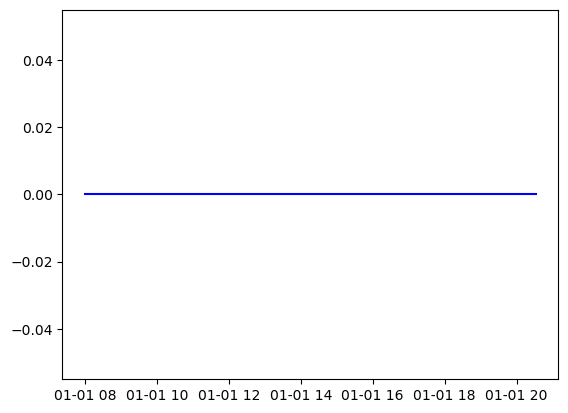

In [46]:
# Initialize lists to store forecasted values and actual values
forecasted_values = []
actual_values = []

# Define the horizon length (20 minutes) and step interval (1 minute)
horizon_length = 20
step_interval = 1

# Iterate through the entire test set with a sliding window of 20 minutes
for i in range(len(df_test_single_day) - horizon_length + 1):
    # Define the start and end timestamps for the current 20-minute window
    start_time = df_test_single_day['ds'].iloc[i]
    end_time = df_test_single_day['ds'].iloc[i + horizon_length - 1]
    
    print(start_time, end_time)
    
    # Generate a date range for the current 20-minute window at 1-minute intervals
    date_range = pd.date_range(start=start_time, end=end_time, freq='T')
    
    # Create a future DataFrame for making predictions within the current window
    future = model.make_future_dataframe(periods=horizon_length, freq='min', include_history=False)
    
    # Set the 'ds' column in the future DataFrame to the date range
    future['ds'] = date_range
    
    # Make predictions for the current 20-minute window
    forecast = model.predict(future)
    
    # Extract the forecasted values for the entire 20-minute horizon
    forecasted_values.extend(forecast['yhat'].values)
    
    # Extract the actual values for the corresponding 20-minute window
    actual_values.extend(df_test_single_day['y'].iloc[i:i + horizon_length].values)

# Calculate the mean absolute error (MAE) for the entire test set
mae = np.mean(np.abs(np.array(actual_values) - np.array(forecasted_values)))



In [66]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01 20:13:00,59.069527,362.783174,683.302195,59.069527,59.069527,468.397462,468.397462,468.397462,467.706006,467.706006,467.706006,0.691456,0.691456,0.691456,0.0,0.0,0.0,527.466989
1,2016-01-01 20:14:00,59.068496,362.285577,697.767176,59.068496,59.068496,468.277171,468.277171,468.277171,467.581816,467.581816,467.581816,0.695355,0.695355,0.695355,0.0,0.0,0.0,527.345667
2,2016-01-01 20:15:00,59.067465,362.793646,679.800812,59.067465,59.067465,468.143375,468.143375,468.143375,467.444123,467.444123,467.444123,0.699252,0.699252,0.699252,0.0,0.0,0.0,527.210841
3,2016-01-01 20:16:00,59.066435,370.577132,688.712817,59.066435,59.066435,467.996072,467.996072,467.996072,467.292923,467.292923,467.292923,0.703149,0.703149,0.703149,0.0,0.0,0.0,527.062507
4,2016-01-01 20:17:00,59.065404,374.191953,696.785228,59.065404,59.065404,467.835258,467.835258,467.835258,467.128214,467.128214,467.128214,0.707044,0.707044,0.707044,0.0,0.0,0.0,526.900661
5,2016-01-01 20:18:00,59.064373,364.670164,685.266396,59.064373,59.064373,467.660927,467.660927,467.660927,466.949989,466.949989,466.949989,0.710938,0.710938,0.710938,0.0,0.0,0.0,526.725300
6,2016-01-01 20:19:00,59.063342,374.613427,687.486533,59.063342,59.063342,467.473076,467.473076,467.473076,466.758246,466.758246,466.758246,0.714831,0.714831,0.714831,0.0,0.0,0.0,526.536419
7,2016-01-01 20:20:00,59.062312,369.790890,685.228531,59.062312,59.062312,467.271700,467.271700,467.271700,466.552978,466.552978,466.552978,0.718722,0.718722,0.718722,0.0,0.0,0.0,526.334011
8,2016-01-01 20:21:00,59.061281,368.104853,687.588311,59.061281,59.061281,467.056792,467.056792,467.056792,466.334180,466.334180,466.334180,0.722612,0.722612,0.722612,0.0,0.0,0.0,526.118073
9,2016-01-01 20:22:00,59.060250,360.197261,690.749931,59.060250,59.060250,466.828347,466.828347,466.828347,466.101846,466.101846,466.101846,0.726501,0.726501,0.726501,0.0,0.0,0.0,525.888597


In [67]:
forecasted_values

[-145.3596084119609,
 -145.40484838307302,
 -145.44860374956772,
 -145.49084595799397,
 -145.53154757370444,
 -145.57068228519438,
 -145.60822491527034,
 -145.6441514250658,
 -145.67843892082433,
 -145.71106566101696,
 -145.74201106011523,
 -145.7712556937767,
 -145.7987813040686,
 -145.8245708017643,
 -145.84860827186728,
 -145.87087897360405,
 -145.89136934582228,
 -145.91006700685338,
 -145.92696075631684,
 -145.94204057637896,
 -145.40484838307302,
 -145.44860374956772,
 -145.49084595799397,
 -145.53154757370444,
 -145.57068228519438,
 -145.60822491527034,
 -145.6441514250658,
 -145.67843892082433,
 -145.71106566101696,
 -145.74201106011523,
 -145.7712556937767,
 -145.7987813040686,
 -145.8245708017643,
 -145.84860827186728,
 -145.87087897360405,
 -145.89136934582228,
 -145.91006700685338,
 -145.92696075631684,
 -145.94204057637896,
 -145.95529763239304,
 -145.44860374956772,
 -145.49084595799397,
 -145.53154757370444,
 -145.57068228519438,
 -145.60822491527034,
 -145.6441514250658

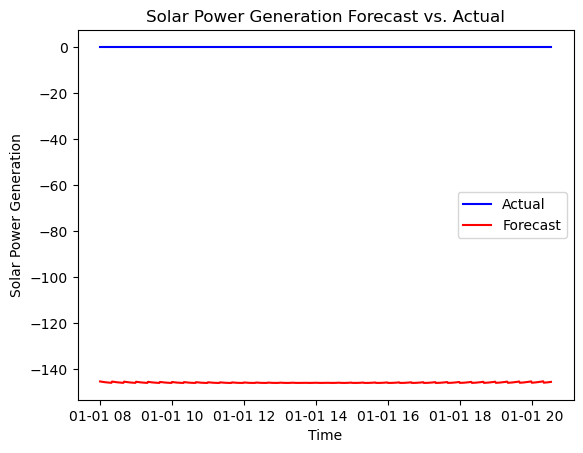

Mean Absolute Error (MAE) for the entire test set: 153.21588362149612


In [47]:
# Optionally, you can plot the actual vs. forecasted values for the entire test set
import matplotlib.pyplot as plt

plt.plot(df_test_single_day['ds'], actual_values[:len(df_test_single_day)], label='Actual', color='b')
plt.plot(df_test_single_day['ds'][:len(forecasted_values)], forecasted_values[:len(df_test_single_day)], label='Forecast', color='r')
plt.xlabel('Time')
plt.ylabel('Solar Power Generation')
plt.title('Solar Power Generation Forecast vs. Actual')
plt.legend()
plt.show()

print(f'Mean Absolute Error (MAE) for the entire test set: {mae}')

In [18]:
 # Initialize lists to store forecasted values and actual values
forecasted_values = []
actual_values = []

# Define the horizon length (20 minutes) and step interval (1 minute)
horizon_length = 20
step_interval = 60  # 1 hour in minutes

# Iterate through the entire test set with a sliding window of 20 minutes at 1-hour intervals
for i in range(0, len(df_test), step_interval):
    # Define the start and end timestamps for the current 20-minute window
    start_time = df_test['ds'].iloc[i]
    end_time = df_test['ds'].iloc[min(i + horizon_length - 1, len(df_test) - 1)]
    
    # Generate a date range for the current 20-minute window at 1-minute intervals
    date_range = pd.date_range(start=start_time, periods=horizon_length, freq='T')
    
    # Create a future DataFrame for making predictions within the current window
    future = model.make_future_dataframe(periods=horizon_length, freq='min', include_history=False)
    
    # Set the 'ds' column in the future DataFrame to the date range
    future['ds'] = date_range
    
    # Make predictions for the current 20-minute window
    forecast = model.predict(future)
    
    # Extract the forecasted values for the entire 20-minute horizon
    forecasted_values.extend(forecast['yhat'].values)
    
    # Extract the actual values for the corresponding 20-minute window
    actual_values.extend(df_test['y'].iloc[i:i + horizon_length].values)

# Calculate the mean absolute error (MAE) for the entire test set
mae = np.mean(np.abs(np.array(actual_values) - np.array(forecasted_values)))

In [27]:
forecasted_df.describe()

,yhat,y
count,108180.000000,108180.000000
mean,-215.805931,187.608478
std,301.621554,292.578322
min,-688.065871,0.000000
25%,-455.909347,0.000000
50%,-260.953937,0.000000
75%,-1.203744,324.800000
max,527.951651,1466.000000


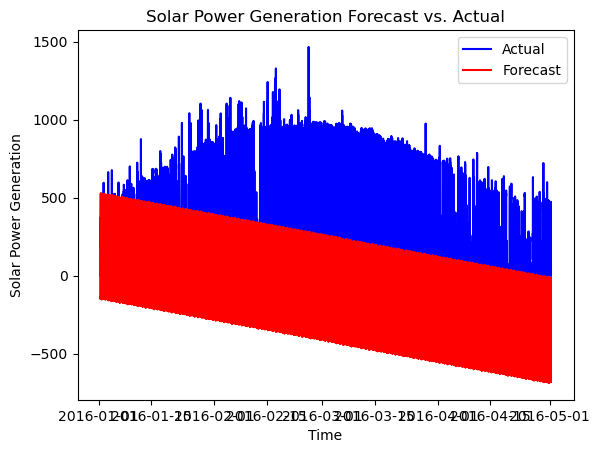

Mean Absolute Error (MAE) for the entire test set: 422.32762098916214


In [25]:
forecasted_df = pd.DataFrame({'ds': df_test['ds'][:len(forecasted_values)], 
                              'yhat': forecasted_values,
                              'y': actual_values})

# Optionally, you can plot the actual vs. forecasted values for the entire test set
plt.plot(forecasted_df['ds'], actual_values, label='Actual', color='b')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Forecast', color='r')
plt.xlabel('Time')
plt.ylabel('Solar Power Generation')
plt.title('Solar Power Generation Forecast vs. Actual')
plt.legend()
plt.show()

print(f'Mean Absolute Error (MAE) for the entire test set: {mae}')